In [1]:
from typing import Tuple

import numpy as np
import pandas as pd
from IPython.core.display import Markdown
from IPython.core.display_functions import display
from sklearn.model_selection import train_test_split

import notebooks.config as config
import notebooks.utils as nb_utils
from src.features.univariate_analysis import UACleaner
from src.utils import Dataset, Metadata, PipelineMetadata, preprocess_init

STAGE = 1
PREVIOUS_STAGE = STAGE - 1

%load_ext autoreload
%autoreload 2

## Load cleaned data and metadata in artifacts

In [2]:
def load_dataset_and_metadata() -> Tuple[Dataset, Metadata]:
    df, metadata = nb_utils.load_artifacts(
        nb_utils.STAGES_DICT[PREVIOUS_STAGE]["name"],
        nb_utils.STAGES_DICT[PREVIOUS_STAGE]["folder_path"],
    )
    return df, metadata

In [3]:
df, metadata = load_dataset_and_metadata()

df.info(memory_usage="deep", max_cols=200)
print()

max_nans_for_rows = df.isna().sum(axis=1).max()
print(f"Max NaNs for rows: {max_nans_for_rows}")
print()

pd.options.display.max_rows = None

print("NaNs for cols")
nans_for_cols = nb_utils.get_nas(df)
display(nans_for_cols[nans_for_cols > 0])

pd.reset_option("display.max_rows", 0)

<class 'pandas.core.frame.DataFrame'>
Index: 29970 entries, 9249043 to 23246511
Data columns (total 168 columns):
 #    Column                                   Non-Null Count  Dtype         
---   ------                                   --------------  -----         
 0    name                                     29970 non-null  string        
 1    short_url                                29970 non-null  string        
 2    price                                    29970 non-null  UInt32        
 3    listing_followers_no                     27188 non-null  UInt16        
 4    location                                 29970 non-null  category      
 5    images_no                                29970 non-null  UInt8         
 6    description                              29970 non-null  string        
 7    gi_brand                                 29970 non-null  category      
 8    gi_model                                 29970 non-null  category      
 9    gi_production_year    

,missing count,missing [%]
ai_range_on_full_battery_km,29843,99.576243
gi_battery_capacity,29813,99.476143
ai_interest_free_credit,29784,99.379379
ai_cash_payment,29687,99.055722
ai_deposit,29497,98.421755
ai_installment_amount,29392,98.071405
ai_installment_no,29360,97.964631
ai_leasing,29183,97.374041
gi_certified,28456,94.948282
ai_credit,28153,93.937271


In [4]:
def train_test_split_nb(df: Dataset) -> Tuple[Dataset, Dataset]:
    df_train, df_test = train_test_split(
        df,
        test_size=config.TEST_SIZE,
        random_state=config.RANDOM_SEED,
    )
    return df_train, df_test

In [5]:
df_orig = df
# Using alias for df_train for making things easier and more neat
df, df_test = train_test_split_nb(df)

In [6]:
n_rows_train, n_cols_train = df.shape

print("Train dataset shape")
print(20 * "-")
print(f"No of rows: {n_rows_train}")
print(f"No of cols: {n_cols_train}")

print()

n_rows_test, n_cols_test = df_test.shape

print("Test dataset shape")
print(20 * "-")
print(f"No of rows: {n_rows_test}")
print(f"No of cols: {n_cols_test}")
print(20 * "-")

Train dataset shape
--------------------
No of rows: 23976
No of cols: 168

Test dataset shape
--------------------
No of rows: 5994
No of cols: 168
--------------------


## Univariate Analysis

### nominal features

In [7]:
@preprocess_init
def ua_nominal_features_nb(df: Dataset, metadata: Metadata) -> Tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    print("Frequencies for nominal features")
    for col in features_info["nominal"]:
        df[col] = df[col].cat.remove_unused_categories()
        display(nb_utils.get_value_counts_freq_with_perc(df, col))
    print("Dropped empty categories")
    print()

    df.loc[df.gi_body_type == "", "gi_body_type"] = np.nan
    print("Replaced ' ' category for 'gi_body_type' with NaN")

    df.gi_fuel_type = pd.Categorical(
        df.gi_fuel_type.astype("object").replace(
            {
                "Hibridni pogon (Benzin)": "Hibridni pogon",
                "Hibridni pogon (Dizel)": "Hibridni pogon",
                "Plug-in hibrid": "Hibridni pogon",
                "Metan CNG": "Benzin + Metan (CNG)",
            }
        ),
        ordered=False,
    )
    print("Grouped simillar categories for 'gi_fuel_type'")

    df.ai_gearbox_type = pd.Categorical(
        df.ai_gearbox_type.astype("object").replace(
            {
                "Automatski": "Automatski / poluautomatski",
                "Poluautomatski": "Automatski / poluautomatski",
            }
        )
    )
    print("Grouped simillar categories for 'ai_gearbox_type'")

    constant_strat_cols = [
        "ai_floating_flywheel",
        "ai_interior_material",
        "ai_interior_color",
        "ai_ownership",
        "ai_import_country",
        "ai_sales_method",
    ]
    modus_strat_cols = [
        col for col in features_info["nominal"] if col not in constant_strat_cols
    ]
    cols_nan_strategy["const_unknown"].extend(constant_strat_cols)
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("NaN constant strategy columns:")
    print(constant_strat_cols)
    print("Extended 'constant' and 'modus' cols_nan_strategy")

    return df, metadata

In [8]:
df, metadata = ua_nominal_features_nb(df=df, metadata=metadata)

Frequencies for nominal features


,count,percentage [%]
location,,
Beograd,3961,16.520687
Novi Sad,1700,7.090424
Niš,973,4.058225
Kragujevac,866,3.611945
Čačak,738,3.078078
...,...,...
KRALJEVO,1,0.004171
Kalanjevci,1,0.004171
Kamendol,1,0.004171


,count,percentage [%]
gi_brand,,
Volkswagen,3814,15.907574
Audi,2575,10.739907
BMW,2165,9.029863
Opel,1857,7.745245
Peugeot,1631,6.802636
...,...,...
Buick,1,0.004171
Lamborghini,1,0.004171
Wartburg,1,0.004171


,count,percentage [%]
gi_model,,
A4,702,2.927928
Octavia,513,2.139640
A6,507,2.114615
A3,493,2.056223
Golf 7,438,1.826827
...,...,...
850,1,0.004171
Grecale,1,0.004171
D2S,1,0.004171


,count,percentage [%]
gi_body_type,,
Hečbek,8088,33.733734
Džip/SUV,4773,19.907407
Limuzina,4458,18.593594
Karavan,3681,15.352853
Monovolumen (MiniVan),1943,8.103937
Kupe,635,2.648482
Kabriolet/Roadster,249,1.038539
Pickup,147,0.613113
,2,0.008342


,count,percentage [%]
gi_fuel_type,,
Dizel,16402,68.410077
Benzin,5871,24.486987
Benzin + Gas (TNG),903,3.766266
Benzin + Metan (CNG),441,1.839339
Hibridni pogon,199,0.829997
Električni pogon,124,0.517184
Hibridni pogon (Benzin),23,0.095929
Hibridni pogon (Dizel),10,0.041708
Plug-in hibrid,2,0.008342


,count,percentage [%]
gi_trade_in,,
NE,17591,73.369203
DA,3003,12.525025
DA (za jeftinije),2248,9.376043
DA (za skuplje),784,3.269937
DA (u istoj ceni),350,1.459793


,count,percentage [%]
ai_floating_flywheel,,
NaN,16329,68.105606
Sa plivajućim zamajcem,4918,20.512179
Bez plivajućeg zamajca,2729,11.382216


,count,percentage [%]
ai_gearbox_type,,
Manuelni 5 brzina,8463,35.297798
Manuelni 6 brzina,8093,33.754588
Automatski / poluautomatski,7280,30.363697
Manuelni 4 brzine,123,0.513013
Automatski,15,0.062563
Poluautomatski,1,0.004171
NaN,1,0.004171


,count,percentage [%]
ai_air_conditioning,,
Automatska klima,16272,67.867868
Manuelna klima,6932,28.912246
Nema klimu,772,3.219887


,count,percentage [%]
ai_color,,
Siva,7718,32.190524
Crna,6238,26.017684
Bela,3541,14.768936
Plava,2185,9.113280
Crvena,1089,4.542042
Srebrna,599,2.498332
Teget,559,2.331498
Braon,444,1.851852
Zelena,409,1.705873


,count,percentage [%]
ai_interior_material,,
Štof,12966,54.079079
Prirodna koža,4103,17.112946
NaN,3259,13.592759
Kombinovana koža,2926,12.203871
Drugi,373,1.555722
Velur,349,1.455622


,count,percentage [%]
ai_interior_color,,
Crna,12244,51.067734
Siva,4576,19.085752
NaN,4184,17.450784
Druga,1334,5.563897
Bež,1136,4.738071
Smeđa,502,2.093760


,count,percentage [%]
ai_propulsion,,
Prednji,17387,72.518352
4x4,4007,16.712546
Zadnji,2091,8.721221
4x4 reduktor,491,2.047881


,count,percentage [%]
ai_vehicle_origin,,
Domaće tablice,14654,61.119453
Na ime kupca,9170,38.246580
Strane tablice,150,0.625626
NaN,2,0.008342


,count,percentage [%]
ai_ownership,,
Vodi se na prodavca,10235,42.688522
NaN,9340,38.955622
Ne vodi se na prodavca,4401,18.355856


,count,percentage [%]
ai_import_country,,
NaN,17914,74.716383
Švajcarska,1640,6.840174
Italija,1105,4.608775
Francuska,989,4.124958
Nemačka,878,3.661995
Holandija,533,2.223056
Belgija,280,1.167835
Norveška,203,0.846680
Austrija,159,0.663163


,count,percentage [%]
ai_sales_method,,
NaN,21544,89.856523
Komisiona,2209,9.213380
Konsignaciona,223,0.930097


Dropped empty categories

Replaced ' ' category for 'gi_body_type' with NaN
Grouped simillar categories for 'gi_fuel_type'
Grouped simillar categories for 'ai_gearbox_type'
NaN constant strategy columns:
['ai_floating_flywheel', 'ai_interior_material', 'ai_interior_color', 'ai_ownership', 'ai_import_country', 'ai_sales_method']
Extended 'constant' and 'modus' cols_nan_strategy


### ordinal features

In [9]:
@preprocess_init
def ua_ordinal_features_nb(
    df: Dataset,
    metadata: Metadata,
) -> Tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    print("Frequencies for ordinal features")
    for col in features_info["ordinal"]:
        df[col] = df[col].cat.remove_unused_categories()
        display(nb_utils.get_value_counts_freq_with_perc(df, col))
    print("Dropped empty categories")
    print()

    df.ai_damage = df.ai_damage.cat.reorder_categories(
        ["Nije oštećen", "Oštećen - u voznom stanju", "Oštećen - nije u voznom stanju"]
    )
    print("Corrected order of 'ai_damage' categories")

    modus_strat_cols = ["ai_engine_emission_class", "ai_damage"]
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("NaN modus strategy columns:")
    print(modus_strat_cols)
    print("Extended 'modus' cols_nan_strategy")

    return df, metadata

In [10]:
df, metadata = ua_ordinal_features_nb(df=df, metadata=metadata)

Frequencies for ordinal features


,count,percentage [%]
ai_engine_emission_class,,
4,7175,29.925759
6,7108,29.646313
5,6621,27.615115
3,2566,10.702369
2,291,1.213714
1,208,0.867534
NaN,7,0.029196


,count,percentage [%]
ai_damage,,
Nije oštećen,23674,98.740407
Oštećen - u voznom stanju,185,0.771605
Oštećen - nije u voznom stanju,112,0.467134
NaN,5,0.020854


Dropped empty categories

Corrected order of 'ai_damage' categories
NaN modus strategy columns:
['ai_engine_emission_class', 'ai_damage']
Extended 'modus' cols_nan_strategy


### numerical features

In [11]:
@preprocess_init
def ua_numerical_features_nb(
    df: Dataset,
    metadata: Metadata,
) -> Tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    idx_to_remove = metadata.idx_to_remove
    cols_nan_strategy = metadata.cols_nan_strategy

    for col in features_info["numerical"]:
        # display(Markdown("#### Feature 'images_no'"))
        nb_utils.show_hist_box_numerical_col(df, col)
        print()

    const_strat_cols_zero = ["listing_followers_no"]
    cols_scheduled_for_deletion = [
        "gi_battery_capacity",
        "ai_deposit",
        "ai_installment_no",
        "ai_cash_payment",
        "ai_range_on_full_battery_km",
    ]
    median_strat_cols = [
        col
        for col in features_info["numerical"]
        if col not in const_strat_cols_zero + cols_scheduled_for_deletion
    ]

    df_cars_with_0_kilometerage = df[df.gi_kilometerage == 0]
    print(f"Cars with 'gi_kilometerage' = 0: {df_cars_with_0_kilometerage.shape[0]}")

    df.drop(df_cars_with_0_kilometerage.index, inplace=True)
    idx_to_remove.extend(df_cars_with_0_kilometerage.index.to_list())
    print("Removed cars with 'gi_kilometerage' = 0")
    print()

    display(df.loc[df.gi_engine_capacity > 0.2 * 1e8])
    df.loc[df.gi_engine_capacity > 0.2 * 1e8, "gi_engine_capacity"] = np.nan
    print(
        "Replaced extreme value of 'gi_engine_capacity' with NaN (will be replaced with median)"
    )
    print()

    print(
        "Cars where 'gi_production_year' = 2024: ",
        (df.gi_production_year == 2024).sum(),
    )
    print()

    listing_names_less_30_hp = df.loc[df.gi_engine_power < 30, "name"].values
    print(
        f"Listing names of cars where 'gi_engine_power' < 30 (horse power): {listing_names_less_30_hp}"
    )
    print()

    features_info["features_to_delete"].extend(cols_scheduled_for_deletion)
    print("Dropped 'gi_battery_capacity' (too many zero values)")
    print("Dropped 'ai_deposit' (label leakage)")
    print("Dropped 'ai_installment_no' (label leakage)")
    print("Dropped 'ai_cash_payment' (label leakage)")
    print("Dropped 'ai_range_on_full_battery_km' (too many zero values)")

    cols_nan_strategy["const_0"].extend(const_strat_cols_zero)
    cols_nan_strategy["median"].extend(median_strat_cols)
    print("NaN fill by 0 strategy columns:")
    print(const_strat_cols_zero)
    print("Extended 'modus' cols_nan_strategy")

    return df, metadata

Univariate analysis of 'listing_followers_no' column
Histogram and box plot


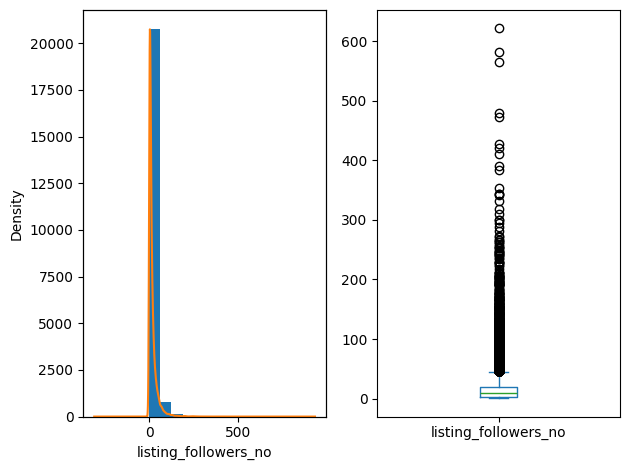

Descriptive statistics


count      21758.0
mean     17.313586
std      27.019121
min            1.0
25%            3.0
50%            9.0
75%           20.0
max          621.0
Name: listing_followers_no, dtype: Float64

Variance: 1.560573353564837
Skewness: 5.9271064044798
Kurtosis: 67.1502687153923

NA values
Count [n]: 2218
Percentage [%]: 9.250917584250917%

Univariate analysis of 'images_no' column
Histogram and box plot


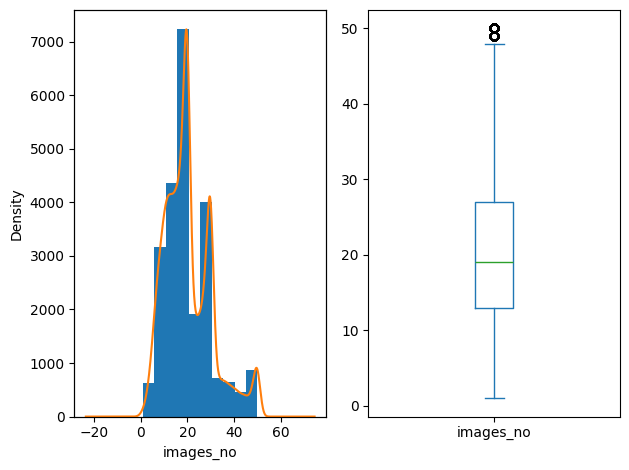

Descriptive statistics


count      23976.0
mean     20.423549
std      10.186724
min            1.0
25%           13.0
50%           19.0
75%           27.0
max           50.0
Name: images_no, dtype: Float64

Variance: 0.4987734409418256
Skewness: 0.8820094862028991
Kurtosis: 0.6691429735623662

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_kilometerage' column
Histogram and box plot


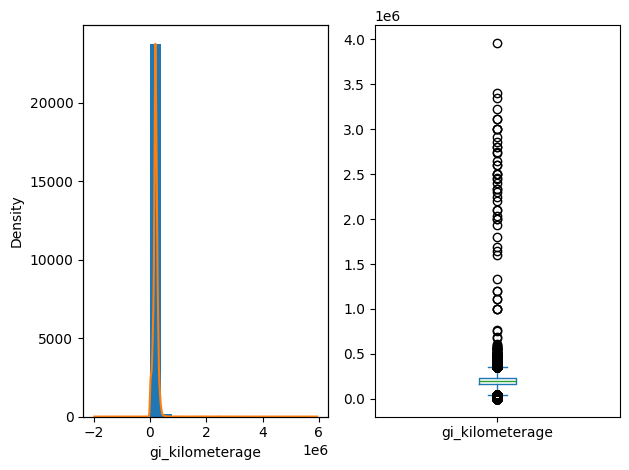

Descriptive statistics


count          23976.0
mean     198926.442276
std      122007.500681
min                0.0
25%           160000.0
50%           195608.0
75%           235503.5
max          3960000.0
Name: gi_kilometerage, dtype: Float64

Variance: 0.6133297277388907
Skewness: 13.335420731298749
Kurtosis: 288.48522079989147

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_production_year' column
Histogram and box plot


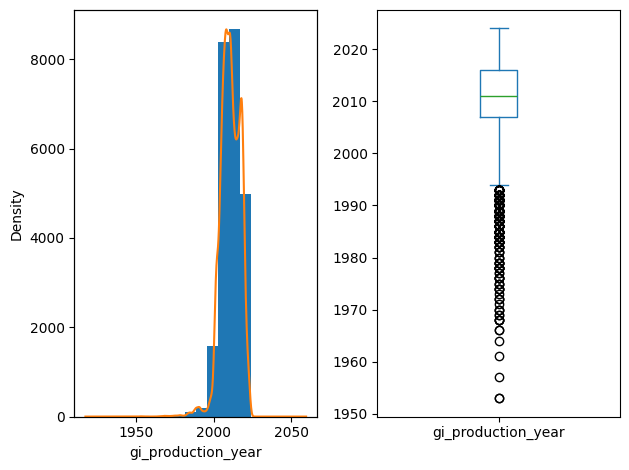

Descriptive statistics


count        23976.0
mean     2010.654321
std         6.318917
min           1953.0
25%           2007.0
50%           2011.0
75%           2016.0
max           2024.0
Name: gi_production_year, dtype: Float64

Variance: 0.0031427169747662155
Skewness: -0.9002758057273476
Kurtosis: 3.5465658549982617

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_engine_capacity' column
Histogram and box plot


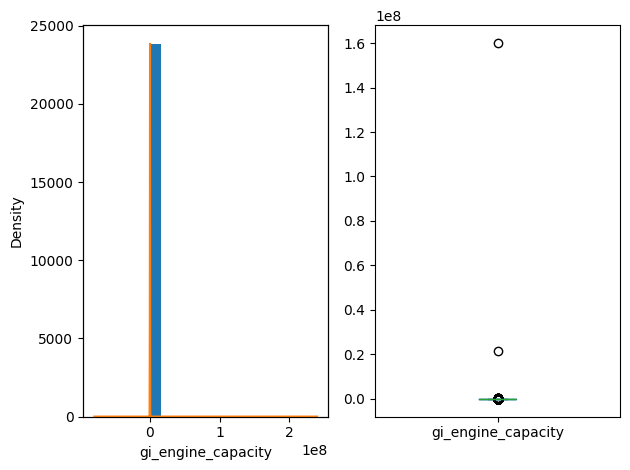

Descriptive statistics


count           23852.0
mean        9494.282408
std      1045613.509048
min               110.0
25%              1461.0
50%              1796.0
75%              1991.0
max         160051414.0
Name: gi_engine_capacity, dtype: Float64

Variance: 110.13086235428021
Skewness: 150.70854523847296
Kurtosis: 23016.855392712267

NA values
Count [n]: 124
Percentage [%]: 0.5171838505171839%

Univariate analysis of 'gi_engine_power' column
Histogram and box plot


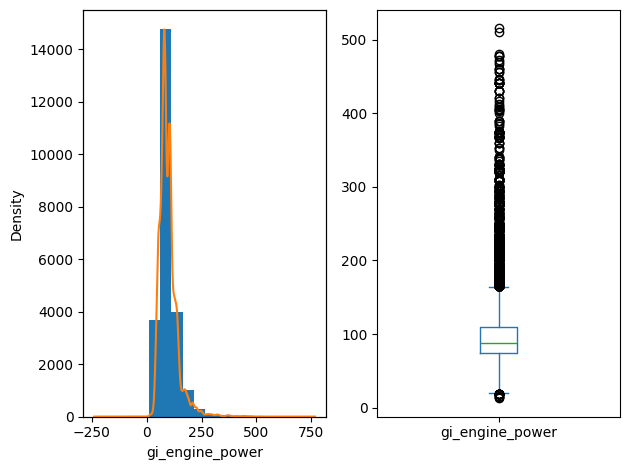

Descriptive statistics


count    23976.000000
mean        98.484276
std         42.866107
min         13.000000
25%         74.000000
50%         88.000000
75%        110.000000
max        515.000000
Name: gi_engine_power, dtype: float64

Variance: 0.43525838876777934
Skewness: 2.530678076229692
Kurtosis: 12.218992363606821

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_battery_capacity' column
Histogram and box plot


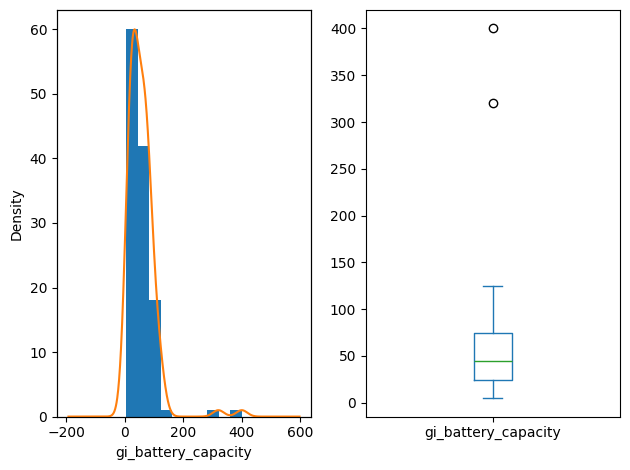

Descriptive statistics


count        123.0
mean      56.76065
std      49.621823
min            5.0
25%           24.0
50%           45.0
75%           75.0
max          400.0
Name: gi_battery_capacity, dtype: Float64

Variance: 0.8742292857831393
Skewness: 3.951887179961589
Kurtosis: 22.759823667480084

NA values
Count [n]: 23853
Percentage [%]: 99.48698698698699%

Univariate analysis of 'ai_seats_no' column
Histogram and box plot


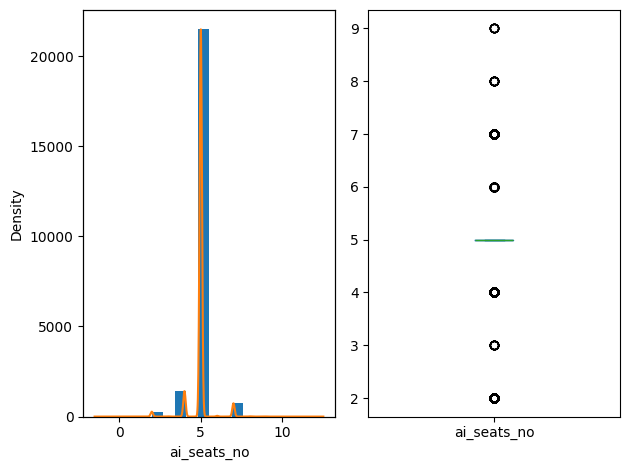

Descriptive statistics


count     23976.0
mean     4.972055
std      0.544085
min           2.0
25%           5.0
50%           5.0
75%           5.0
max           9.0
Name: ai_seats_no, dtype: Float64

Variance: 0.10942854261121872
Skewness: -0.3890996335689603
Kurtosis: 15.096369438243926

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'ai_deposit' column
Histogram and box plot


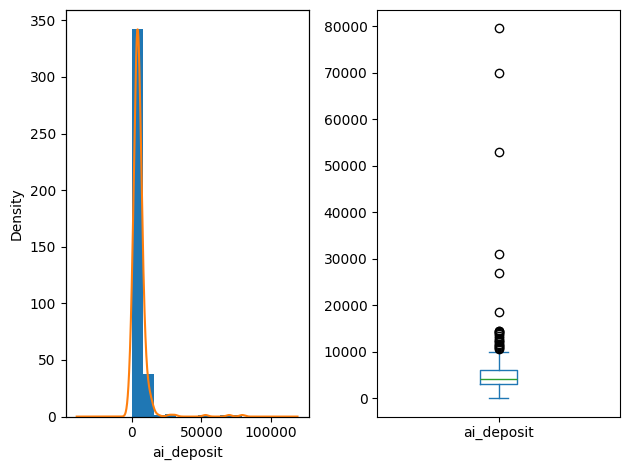

Descriptive statistics


count          386.0
mean     5235.163212
std      6513.712856
min             30.0
25%           3000.0
50%           4200.0
75%           6000.0
max          79480.0
Name: ai_deposit, dtype: Float64

Variance: 1.244223454380122
Skewness: 7.7269214757290925
Kurtosis: 75.06535632602021

NA values
Count [n]: 23590
Percentage [%]: 98.39005672339005%

Univariate analysis of 'ai_installment_no' column
Histogram and box plot


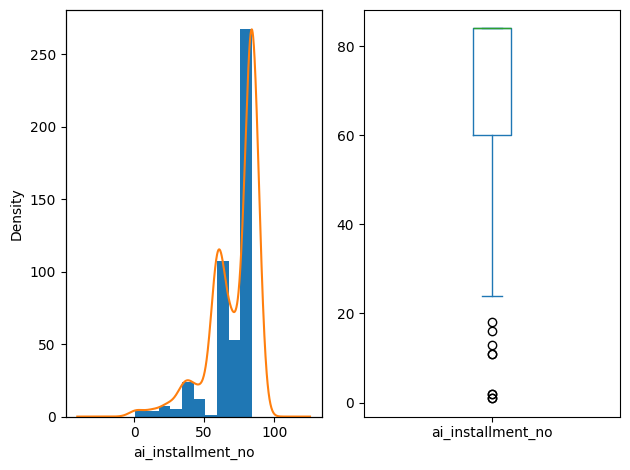

Descriptive statistics


count        484.0
mean     71.305785
std      17.454866
min            1.0
25%           60.0
50%           84.0
75%           84.0
max           84.0
Name: ai_installment_no, dtype: Float64

Variance: 0.24478891830896082
Skewness: -1.5245131112083667
Kurtosis: 2.2520084953395285

NA values
Count [n]: 23492
Percentage [%]: 97.9813146479813%

Univariate analysis of 'ai_installment_amount' column
Histogram and box plot


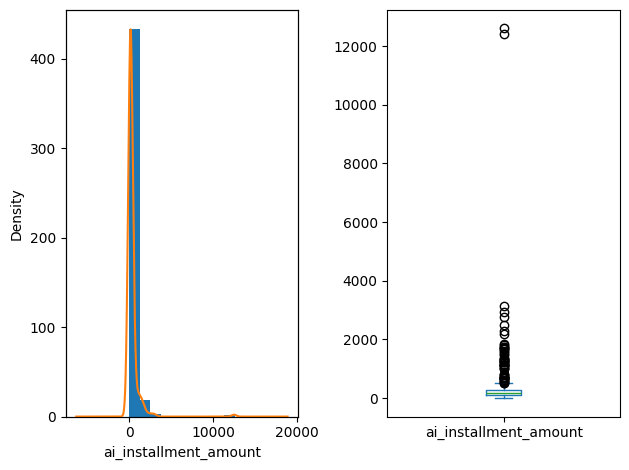

Descriptive statistics


count         457.0
mean     361.148796
std      908.290299
min             1.0
25%           118.0
50%           170.0
75%           271.0
max         12600.0
Name: ai_installment_amount, dtype: Float64

Variance: 2.5150029788836297
Skewness: 10.80013636108
Kurtosis: 138.01889465540717

NA values
Count [n]: 23519
Percentage [%]: 98.09392726059393%

Univariate analysis of 'ai_cash_payment' column
Histogram and box plot


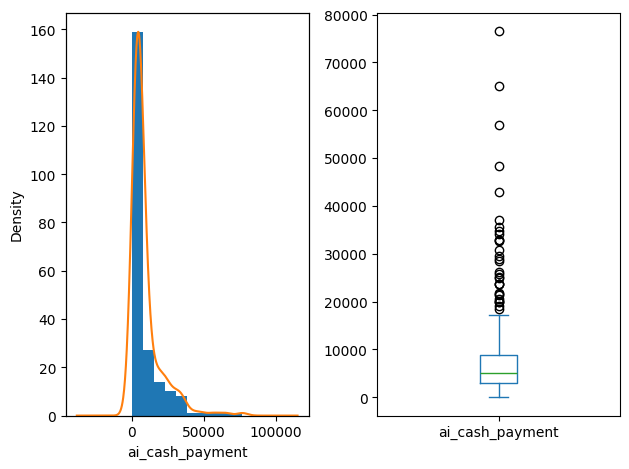

Descriptive statistics


count           223.0
mean      9014.919283
std      10967.519298
min               1.0
25%            3075.0
50%            5000.0
75%            8940.0
max           76600.0
Name: ai_cash_payment, dtype: Float64

Variance: 1.216596505670031
Skewness: 2.9352160338443314
Kurtosis: 10.76807763237096

NA values
Count [n]: 23753
Percentage [%]: 99.0699032365699%

Univariate analysis of 'ai_range_on_full_battery_km' column
Histogram and box plot


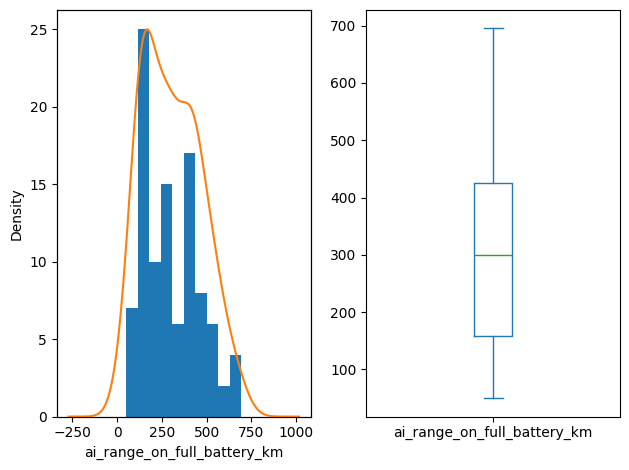

Descriptive statistics


count         100.0
mean         305.53
std      160.957705
min            50.0
25%           157.5
50%           300.0
75%           424.5
max           695.0
Name: ai_range_on_full_battery_km, dtype: Float64

Variance: 0.5268147331036424
Skewness: 0.36710159640328804
Kurtosis: -0.8090055086911687

NA values
Count [n]: 23876
Percentage [%]: 99.58291624958292%

Cars with 'gi_kilometerage' = 0: 2
Removed cars with 'gi_kilometerage' = 0



,name,short_url,price,listing_followers_no,location,images_no,description,gi_brand,gi_model,gi_production_year,...,o_Garažiran,o_Kupljen_nov_u_Srbiji,o_Oldtimer,o_Prilagođeno_invalidima,o_Prvi_vlasnik,o_Restauriran,o_Rezervni_ključ,o_Servisna_knjiga,o_Test_vozilo,o_Tuning
id,,,,,,,,,,,,,,,,,,,,,
22503872,Mercedes Benz E 200 CDi Classic,https://www.polovniautomobili.com/auto-oglasi/...,4500,6,Čačak,20,Uslužna prodaja- Vozilo se nalazi kod nas Polo...,Mercedes Benz,E 200,2004,...,False,False,False,False,False,False,True,False,False,False
23210877,Opel Insignia EXCLUSIVE,https://www.polovniautomobili.com/auto-oglasi/...,15200,4,Leštane,30,Opel Insignija 1.6D 136 KS 6 brz. Auto je u na...,Opel,Insignia,2019,...,True,False,False,False,False,False,True,True,False,False


Replaced extreme value of 'gi_engine_capacity' with NaN (will be replaced with median)

Cars where 'gi_production_year' = 2024:  5

Listing names of cars where 'gi_engine_power' < 30 (horse power): <StringArray>
[ 'Zastava 750 presla 38.400',            'Zastava 750 750',
                'Opel Kadett',            'Renault R 4 gtl',
             'Zastava 750 LE',                'Zastava 750',
      'Zastava 750 LE sa Reg',         'Zastava 750 750 le',
                'Zastava 750',                'Zastava 850',
            'Renault R 4 GTL',             'Renault R 4 tl',
            'Fiat 126 126PLG',           'Fiat 126 Peglica',
                'Zastava 750',               'ZhiDou Icaro',
     'Renault Twizy eletktro',                'Zastava 750',
              'Renault Twizy',   'Citroen Ami ami electric',
             'Zastava 750 LE',                'Trabant 601',
          'Fiat Seicento 0.9',      'Volkswagen Buba 1200J',
 'Renault Twizy elektro  8kw',          'Fiat 500L Berli

In [12]:
df, metadata = ua_numerical_features_nb(df=df, metadata=metadata)

### binary features

In [13]:
@preprocess_init
def ua_binary_features_nb(
    df: Dataset,
    metadata: Metadata,
) -> Tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy
    
    display(Markdown("### Categories for every binary column"))
    for col in features_info["binary"]:
        display(nb_utils.get_value_counts_freq_with_perc(df, col))

    cols_scheduled_for_deletion = [
        "e_Fabrički_ugrađeno_dečije_sedište",
        "e_Volan_u_kombinaciji_drvo_ili_koža",
        "o_Oldtimer",
        "o_Prilagođeno_invalidima",
        "o_Restauriran",
        "o_Test_vozilo",
        "o_Tuning",
    ]
    print(f"Columns scheduled for deletion:\n{cols_scheduled_for_deletion}")
    print()

    const_false_strat_cols = ["ai_credit", "ai_interest_free_credit", "ai_leasing"]
    modus_strat_cols = [
        col
        for col in features_info["binary"]
        if col not in cols_scheduled_for_deletion + const_false_strat_cols
    ]
    print("NaN fill by False strategy columns:")
    print(const_false_strat_cols)
    print()

    cols_nan_strategy["const_false"].extend(const_false_strat_cols)
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("Extended 'const_false' and 'modus' cols_nan_strategy")

    features_info["features_to_delete"].extend(cols_scheduled_for_deletion)

    return df, metadata

In [14]:
df, metadata = ua_binary_features_nb(df=df, metadata=metadata)

### Categories for every binary column

,count,percentage [%]
s_ABS,,
True,22246,92.792192
False,1728,7.207808


,count,percentage [%]
s_ASR,,
True,17404,72.595312
False,6570,27.404688


,count,percentage [%]
s_Airbag_za_suvozača,,
True,22403,93.447068
False,1571,6.552932


,count,percentage [%]
s_Airbag_za_vozača,,
True,22542,94.026862
False,1432,5.973138


,count,percentage [%]
s_Alarm,,
False,17452,72.795528
True,6522,27.204472


,count,percentage [%]
s_Asistencija_praćenja_trake,,
False,20576,85.826312
True,3398,14.173688


,count,percentage [%]
s_Automatsko_kočenje,,
False,20346,84.866939
True,3628,15.133061


,count,percentage [%]
s_Blokada_motora,,
False,17419,72.657879
True,6555,27.342121


,count,percentage [%]
s_Bočni_airbag,,
True,20824,86.860766
False,3150,13.139234


,count,percentage [%]
s_Centralno_zaključavanje,,
True,22029,91.887044
False,1945,8.112956


,count,percentage [%]
s_Child_lock,,
True,13349,55.681155
False,10625,44.318845


,count,percentage [%]
s_ESP,,
True,18382,76.674731
False,5592,23.325269


,count,percentage [%]
s_Kodiran_ključ,,
True,15143,63.164261
False,8831,36.835739


,count,percentage [%]
s_Mehanička_zaštita,,
False,22509,93.889213
True,1465,6.110787


,count,percentage [%]
s_OBD_zaštita,,
False,19397,80.908484
True,4577,19.091516


,count,percentage [%]
s_Senzor_mrtvog_ugla,,
False,21946,91.540836
True,2028,8.459164


,count,percentage [%]
s_Ulazak_bez_ključa,,
False,20116,83.907567
True,3858,16.092433


,count,percentage [%]
s_Vazdušni_jastuci_za_kolena,,
False,19007,79.281722
True,4967,20.718278


,count,percentage [%]
e_360_kamera,,
False,23081,96.275131
True,893,3.724869


,count,percentage [%]
e_AUX_konekcija,,
False,13781,57.483107
True,10193,42.516893


,count,percentage [%]
e_Adaptivna_svetla,,
False,19260,80.337032
True,4714,19.662968


,count,percentage [%]
e_Adaptivni_tempomat,,
False,20519,85.588554
True,3455,14.411446


,count,percentage [%]
e_Aluminijumske_felne,,
True,17003,70.922666
False,6971,29.077334


,count,percentage [%]
e_Ambijentalno_osvetljenje,,
False,20694,86.318512
True,3280,13.681488


,count,percentage [%]
e_Android_Auto,,
False,21534,89.822307
True,2440,10.177693


,count,percentage [%]
e_Apple_CarPlay,,
False,21596,90.080921
True,2378,9.919079


,count,percentage [%]
e_Asistencija_za_kretanje_na_uzbrdici,,
False,15308,63.852507
True,8666,36.147493


,count,percentage [%]
e_Automatsko_parkiranje,,
False,22261,92.854759
True,1713,7.145241


,count,percentage [%]
e_Automatsko_zatamnjivanje_retrovizora,,
False,17193,71.715191
True,6781,28.284809


,count,percentage [%]
e_Autonomna_vožnja,,
False,23052,96.154167
True,922,3.845833


,count,percentage [%]
e_Bluetooth,,
False,13156,54.876116
True,10818,45.123884


,count,percentage [%]
e_Branici_u_boji_auta,,
True,15395,64.2154
False,8579,35.7846


,count,percentage [%]
e_Brisači_prednjih_farova,,
False,21733,90.652373
True,2241,9.347627


,count,percentage [%]
e_CD_changer,,
False,20832,86.894135
True,3142,13.105865


,count,percentage [%]
e_DPF_filter,,
False,14133,58.951364
True,9841,41.048636


,count,percentage [%]
e_DVD_ili_TV,,
False,21616,90.164345
True,2358,9.835655


,count,percentage [%]
e_Daljinsko_zaključavanje,,
True,20260,84.508217
False,3714,15.491783


,count,percentage [%]
e_Digitalni_radio,,
False,18664,77.851005
True,5310,22.148995


,count,percentage [%]
e_Dnevna_svetla,,
True,12551,52.352549
False,11423,47.647451


,count,percentage [%]
e_Držači_za_čaše,,
True,18451,76.962543
False,5523,23.037457


,count,percentage [%]
e_Ekran_na_dodir,,
False,17908,74.697589
True,6066,25.302411


,count,percentage [%]
e_Električni_podizači,,
True,21864,91.198799
False,2110,8.801201


,count,percentage [%]
e_Električni_retrovizori,,
True,20354,84.900309
False,3620,15.099691


,count,percentage [%]
e_Elektro_otvaranje_prtljažnika,,
False,13785,57.499791
True,10189,42.500209


,count,percentage [%]
e_Elektro_podesiva_sedišta,,
False,18550,77.37549
True,5424,22.62451


,count,percentage [%]
e_Elektro_sklopivi_retrovizori,,
False,17204,71.761074
True,6770,28.238926


,count,percentage [%]
e_Elektro_zatvaranje_prtljažnika,,
False,21849,91.136231
True,2125,8.863769


,count,percentage [%]
e_Elektronska_ručna_kočnica,,
False,16700,69.658797
True,7274,30.341203


,count,percentage [%]
e_Fabrički_ugrađeno_dečije_sedište,,
False,23886,99.632936
True,88,0.367064


,count,percentage [%]
e_Glasovne_komande,,
False,19652,81.972136
True,4322,18.027864


,count,percentage [%]
e_Grejanje_sedišta,,
False,17609,73.450405
True,6365,26.549595


,count,percentage [%]
e_Grejanje_volana,,
False,23153,96.575457
True,821,3.424543


,count,percentage [%]
e_Grejači_retrovizora,,
True,17871,74.543255
False,6103,25.456745


,count,percentage [%]
e_Grejači_vetrobranskog_stakla,,
False,19294,80.478852
True,4680,19.521148


,count,percentage [%]
e_Hands_free,,
False,16634,69.383499
True,7340,30.616501


,count,percentage [%]
e_Hard_disk,,
False,22330,93.142571
True,1644,6.857429


,count,percentage [%]
e_Head_up_display,,
False,23093,96.325186
True,881,3.674814


,count,percentage [%]
e_ISOFIX_sistem,,
True,17241,71.915408
False,6733,28.084592


,count,percentage [%]
e_Indikator_niskog_pritiska_u_gumama,,
False,14176,59.130725
True,9798,40.869275


,count,percentage [%]
e_Kamera,,
False,20098,83.832485
True,3876,16.167515


,count,percentage [%]
e_Keramičke_kočnice,,
False,23777,99.178276
True,197,0.821724


,count,percentage [%]
e_Kožni_volan,,
True,15461,64.490698
False,8513,35.509302


,count,percentage [%]
e_Krovni_nosač,,
False,17792,74.213732
True,6182,25.786268


,count,percentage [%]
e_Kuka_za_vuču,,
False,21313,88.900476
True,2661,11.099524


,count,percentage [%]
e_LED_prednja_svetla,,
False,15968,66.605489
True,8006,33.394511


,count,percentage [%]
e_LED_zadnja_svetla,,
False,16072,67.039293
True,7902,32.960707


,count,percentage [%]
e_MP3,,
False,13352,55.693668
True,10622,44.306332


,count,percentage [%]
e_Masažna_sedišta,,
False,23370,97.480604
True,604,2.519396


,count,percentage [%]
e_Matrix_farovi,,
False,22758,94.927838
True,1216,5.072162


,count,percentage [%]
e_Memorija_sedišta,,
False,22370,93.309419
True,1604,6.690581


,count,percentage [%]
e_Metalik_boja,,
True,13854,57.787603
False,10120,42.212397


,count,percentage [%]
e_Modovi_vožnje,,
False,19655,81.98465
True,4319,18.01535


,count,percentage [%]
e_Multifunkcionalni_volan,,
True,15425,64.340536
False,8549,35.659464


,count,percentage [%]
e_Multimedija,,
False,14521,60.569784
True,9453,39.430216


,count,percentage [%]
e_Naslon_za_ruku,,
True,15402,64.244598
False,8572,35.755402


,count,percentage [%]
e_Navigacija,,
False,15344,64.00267
True,8630,35.99733


,count,percentage [%]
e_Ostava_sa_hlađenjem,,
False,16058,66.980896
True,7916,33.019104


,count,percentage [%]
e_Otvor_za_skije,,
False,20754,86.568783
True,3220,13.431217


,count,percentage [%]
e_Paljenje_bez_ključa,,
False,18781,78.339034
True,5193,21.660966


,count,percentage [%]
e_Panorama_krov,,
False,21947,91.545007
True,2027,8.454993


,count,percentage [%]
e_Parking_senzori,,
False,12901,53.812464
True,11073,46.187536


,count,percentage [%]
e_Podešavanje_volana_po_visini,,
True,19370,80.795862
False,4604,19.204138


,count,percentage [%]
e_Postolje_za_bežično_punjenje_telefona,,
False,23034,96.079086
True,940,3.920914


,count,percentage [%]
e_Prednja_noćna_kamera,,
False,23620,98.5234
True,354,1.4766


,count,percentage [%]
e_Privlačenje_vrata_pri_zatvaranju,,
False,23494,97.997831
True,480,2.002169


,count,percentage [%]
e_Putni_računar,,
True,18739,78.163844
False,5235,21.836156


,count,percentage [%]
e_Radio_CD,,
True,16903,70.505548
False,7071,29.494452


,count,percentage [%]
e_Radio_ili_Kasetofon,,
True,13721,57.232836
False,10253,42.767164


,count,percentage [%]
e_Retrovizor_se_obara_pri_rikvercu,,
False,21140,88.17886
True,2834,11.82114


,count,percentage [%]
e_Rezervni_točak,,
False,12528,52.256611
True,11446,47.743389


,count,percentage [%]
e_Ručice_za_menjanje_brzina_na_volanu,,
False,21196,88.412447
True,2778,11.587553


,count,percentage [%]
e_Sedišta_podesiva_po_visini,,
True,16510,68.866272
False,7464,31.133728


,count,percentage [%]
e_Senzori_za_kišu,,
True,12605,52.577793
False,11369,47.422207


,count,percentage [%]
e_Senzori_za_svetla,,
True,11995,50.033369
False,11979,49.966631


,count,percentage [%]
e_Servo_volan,,
True,22426,93.543005
False,1548,6.456995


,count,percentage [%]
e_Sportska_sedišta,,
False,19401,80.925169
True,4573,19.074831


,count,percentage [%]
e_Sportsko_vešanje,,
False,21810,90.973555
True,2164,9.026445


,count,percentage [%]
e_Start_stop_sistem,,
False,17600,73.412864
True,6374,26.587136


,count,percentage [%]
e_Subwoofer,,
False,22340,93.184283
True,1634,6.815717


,count,percentage [%]
e_Svetla_za_maglu,,
True,17508,73.029115
False,6466,26.970885


,count,percentage [%]
e_Tempomat,,
True,14819,61.812797
False,9155,38.187203


,count,percentage [%]
e_Tonirana_stakla,,
True,18633,77.721699
False,5341,22.278301


,count,percentage [%]
e_Torba_za_skije,,
False,23613,98.494202
True,361,1.505798


,count,percentage [%]
e_USB,,
False,14206,59.255861
True,9768,40.744139


,count,percentage [%]
e_Upravljanje_na_sva_četiri_točka,,
False,23158,96.596313
True,816,3.403687


,count,percentage [%]
e_Utičnica_od_12V,,
True,16578,69.149912
False,7396,30.850088


,count,percentage [%]
e_Vazdušno_vešanje,,
False,23185,96.708935
True,789,3.291065


,count,percentage [%]
e_Ventilacija_sedišta,,
False,23483,97.951948
True,491,2.048052


,count,percentage [%]
e_Virtuelna_tabla,,
False,22378,93.342788
True,1596,6.657212


,count,percentage [%]
e_Volan_u_kombinaciji_drvo_ili_koža,,
False,23837,99.428548
True,137,0.571452


,count,percentage [%]
e_Webasto,,
False,23187,96.717277
True,787,3.282723


,count,percentage [%]
e_Xenon_svetla,,
False,18326,76.441145
True,5648,23.558855


,count,percentage [%]
e_Zaključavanje_diferencijala,,
False,23220,96.854926
True,754,3.145074


,count,percentage [%]
e_Zavesice_na_zadnjim_prozorima,,
False,23006,95.962292
True,968,4.037708


,count,percentage [%]
e_Šiber,,
False,22454,93.659798
True,1520,6.340202


,count,percentage [%]
o_Garancija,,
False,17865,74.518228
True,6109,25.481772


,count,percentage [%]
o_Garažiran,,
False,14549,60.686577
True,9425,39.313423


,count,percentage [%]
o_Kupljen_nov_u_Srbiji,,
False,21781,90.85259
True,2193,9.14741


,count,percentage [%]
o_Oldtimer,,
False,23905,99.712188
True,69,0.287812


,count,percentage [%]
o_Prilagođeno_invalidima,,
False,23967,99.970802
True,7,0.029198


,count,percentage [%]
o_Prvi_vlasnik,,
False,19388,80.870944
True,4586,19.129056


,count,percentage [%]
o_Restauriran,,
False,23923,99.78727
True,51,0.21273


,count,percentage [%]
o_Rezervni_ključ,,
False,12117,50.542254
True,11857,49.457746


,count,percentage [%]
o_Servisna_knjiga,,
False,13442,56.069075
True,10532,43.930925


,count,percentage [%]
o_Test_vozilo,,
False,23902,99.699675
True,72,0.300325


,count,percentage [%]
o_Tuning,,
False,23856,99.5078
True,118,0.4922


,count,percentage [%]
ai_doors_no,,
True,21503,89.693001
False,2469,10.298657
<NA>,2,0.008342


,count,percentage [%]
ai_credit,,
<NA>,22518,93.926754
True,1456,6.073246


,count,percentage [%]
ai_interest_free_credit,,
<NA>,23825,99.378493
True,149,0.621507


,count,percentage [%]
ai_leasing,,
<NA>,23355,97.418036
True,619,2.581964


Columns scheduled for deletion:
['e_Fabrički_ugrađeno_dečije_sedište', 'e_Volan_u_kombinaciji_drvo_ili_koža', 'o_Oldtimer', 'o_Prilagođeno_invalidima', 'o_Restauriran', 'o_Test_vozilo', 'o_Tuning']

NaN fill by False strategy columns:
['ai_credit', 'ai_interest_free_credit', 'ai_leasing']

Extended 'const_false' and 'modus' cols_nan_strategy


### other features

In [15]:
@preprocess_init
def ua_other_features_nb(
    df: Dataset,
    metadata: Metadata,
) -> Tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    # Subset of other columns
    other_columns = ["gi_certified", "ai_registered_until"]

    display(Markdown("### Descriptive statistics of other columns"))
    display(df[other_columns].describe())
    print("Missing values of other columns")
    nb_utils.get_nas(df[other_columns])  # type: ignore

    today_date = np.datetime64("2024-01")

    df.gi_certified = pd.to_numeric(
        (df.gi_certified - today_date).dt.days.astype("Int64"),  # type: ignore
        downcast="signed",
    )
    df.ai_registered_until = pd.to_numeric(
        (df.ai_registered_until - today_date).dt.days.astype("Int64"),  # type: ignore
        downcast="signed",
    )
    print(
        "Transformed 'gi_certified' and 'ai_registered_until' to difference of '2024-01' date and corresponding dates"
    )
    print()

    display(Markdown("### Univariate analysis of transformed other columns"))
    for col in other_columns:
        nb_utils.show_hist_box_numerical_col(df, col)
    print()

    cols_nan_strategy["const_0"].extend(other_columns)
    print("NaN constant 0 strategy columns:")
    print(other_columns)

    for col in other_columns:
        features_info["other"].remove(col)
    print(f"Removed {other_columns} from other features")

    features_info["numerical"].extend(other_columns)
    print(f"Added {other_columns} to numerical features")

    return df, metadata

### Descriptive statistics of other columns

,gi_certified,ai_registered_until
count,1210,13654
mean,2027-02-03 09:40:45.619834624,2024-07-08 12:23:56.414237440
min,2022-05-01 00:00:00,2021-06-01 00:00:00
25%,2025-12-01 00:00:00,2024-04-01 00:00:00
50%,2027-04-01 00:00:00,2024-07-01 00:00:00
75%,2028-01-01 00:00:00,2024-11-01 00:00:00
max,2033-12-01 00:00:00,2025-03-01 00:00:00


Missing values of other columns
Transformed 'gi_certified' and 'ai_registered_until' to difference of '2024-01' date and corresponding dates



### Univariate analysis of transformed other columns

Univariate analysis of 'gi_certified' column
Histogram and box plot


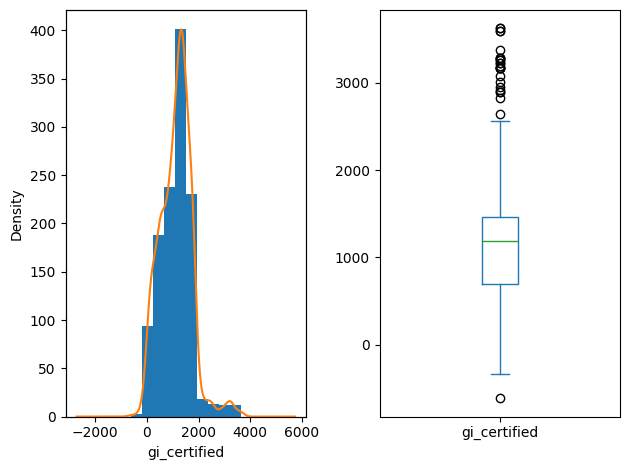

Descriptive statistics


count         1210.0
mean     1129.403306
std       609.234467
min           -610.0
25%            700.0
50%           1186.0
75%           1461.0
max           3622.0
Name: gi_certified, dtype: Float64

Variance: 0.5394303914621355
Skewness: 0.5166862476236815
Kurtosis: 1.4767214621681468

NA values
Count [n]: 22764
Percentage [%]: 94.95286560440476%
Univariate analysis of 'ai_registered_until' column
Histogram and box plot


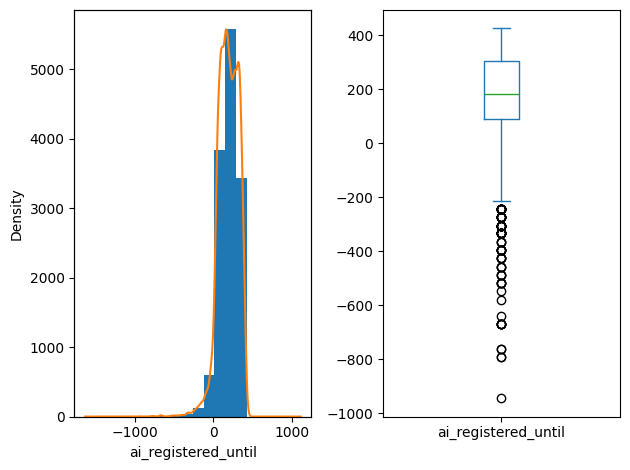

Descriptive statistics


count       13654.0
mean     189.516625
std      127.599252
min          -944.0
25%            91.0
50%           182.0
75%           305.0
max           425.0
Name: ai_registered_until, dtype: Float64

Variance: 0.6732879054952757
Skewness: -0.937859681149509
Kurtosis: 3.396157777134711

NA values
Count [n]: 10320
Percentage [%]: 43.04663385334112%

NaN constant 0 strategy columns:
['gi_certified', 'ai_registered_until']
Removed ['gi_certified', 'ai_registered_until'] from other features
Added ['gi_certified', 'ai_registered_until'] to numerical features


In [16]:
df, metadata = ua_other_features_nb(df=df, metadata=metadata)

## Testing

### Test individual components

In [17]:
class TestNotebook:
    # Testing only df_train
    def test_ua_features(self, features_type):
        df_1, metadata_1 = load_dataset_and_metadata()
        df_2, metadata_2 = load_dataset_and_metadata()

        # Get df_train
        df_1, _ = train_test_split_nb(df_1)
        df_2, _ = train_test_split_nb(df_2)

        func_name_ua = f"ua_{features_type}_features"
        func_name_nb = f"{func_name_ua}_nb"

        uacleaner_obj = UACleaner(PipelineMetadata())

        # Get function from class object from .py file
        func_ua = getattr(uacleaner_obj, func_name_ua)
        # Get function defined in this notebook
        func_nb = globals()[func_name_nb]

        df_ua, metadata_ua = func_ua(df=df_1, metadata=metadata_1)
        df_nb, metadata_nb = func_nb(df=df_2, metadata=metadata_2)

        pd.testing.assert_frame_equal(df_ua, df_nb)
        assert metadata_ua == metadata_nb

        # Test features info for duplicates
        nb_utils.test_features_info_duplicates(metadata_nb.features_info)
        nb_utils.test_features_info_duplicates(metadata_ua.features_info)

        # Test columns nan strategy for duplicates
        nb_utils.test_cols_nan_strategy_duplicates(metadata_nb.cols_nan_strategy)
        nb_utils.test_cols_nan_strategy_duplicates(metadata_ua.cols_nan_strategy)

    def start(self):
        self.test_ua_features("nominal")
        self.test_ua_features("ordinal")
        self.test_ua_features("numerical")
        self.test_ua_features("binary")

In [ ]:
test_obj = TestNotebook()
test_obj.start()

### Test whole component

In [19]:
@preprocess_init
def test_whole_component(
    df: Dataset,
    metadata: Metadata,
):
    df_init, metadata_init = load_dataset_and_metadata()

    # Get df_train
    df_init, _ = train_test_split_nb(df_init)

    df_ua, metadata_ua = UACleaner.clean(df=df_init, metadata=metadata_init)

    pd.testing.assert_frame_equal(df, df_ua)
    assert metadata == metadata_ua

    # Test features info for duplicates
    nb_utils.test_features_info_duplicates(metadata.features_info)
    nb_utils.test_features_info_duplicates(metadata_ua.features_info)

    # Test features info with columns
    nb_utils.test_features_info_with_columns(df, metadata.features_info)
    nb_utils.test_features_info_with_columns(df_ua, metadata_ua.features_info)

    # Test columns nan strategy for duplicates
    nb_utils.test_cols_nan_strategy_duplicates(metadata.cols_nan_strategy)
    nb_utils.test_cols_nan_strategy_duplicates(metadata_ua.cols_nan_strategy)

    # Test columns nan strategy with features info
    nb_utils.test_cols_nan_strategy_with_features_info(
        metadata.cols_nan_strategy, metadata.features_info
    )
    nb_utils.test_cols_nan_strategy_with_features_info(
        metadata_ua.cols_nan_strategy, metadata_ua.features_info
    )

In [20]:
test_whole_component(df=df, metadata=metadata)

## Save cleaned data and metadata in artifacts

In [21]:
nb_utils.save_artifacts(
    nb_utils.STAGES_DICT[STAGE]["name"],
    nb_utils.STAGES_DICT[STAGE]["folder_path"],
    df,
    metadata,
)